In [1]:
#Importing libraries, pandas for df and matplotlib for plotting graphs
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

##import fbprophet for forecasting sales and MLXTend for item
from fbprophet import Prophet
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori


##hiding loggs and warnings
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")

In [2]:
##filenames
transc_data_file = 'dataset1.csv'
traffic_data_file = 'dataset2.csv'

##reading files in pandas dataframe
transc_data = pd.read_csv(transc_data_file)
traffic_data = pd.read_csv(traffic_data_file)

Prior data manipulations:

    1)Take care of date format
    
    2)Converting all the currency with respect to curr1

In [3]:
##read the date column in datetime format
transc_data['Order date'] = pd.to_datetime(transc_data['Order date'], format='%d%b%Y %H:%M:%f')

##convert unit price and line_total in curr1
transc_data.loc[transc_data['Order\'s currency']=='Curr2', ['Unit Price', 'Line_Total']] *=0.6345
transc_data.loc[transc_data['Order\'s currency']=='Curr3', ['Unit Price', 'Line_Total']] *=0.4598


In [4]:
#few rows of transaction data
transc_data.head()

,Store_new,Order_ID,Line_ID,QTY,Order date,Item_was_refunded(1=Yes/0=No),Returning_Customer (1=Yes/0=No),Order's currency,Product,Gender,Brand Code,Size Code,Unit Price,Line_Total
0,Store7,2600333511,4455787975,1,2016-02-26 16:47:00.460,0,0,Curr1,Footwear,M,ABC,110,43.0,43.0
1,Store7,2600350023,4455829063,1,2016-02-26 16:51:00.450,1,1,Curr1,Footwear,W,DGC,80,91.0,91.0
2,Store7,2621780295,4499950215,1,2016-02-29 18:38:00.230,0,1,Curr1,Clothing,M,SFG,90,90.0,90.0
3,Store7,2623558279,4503253447,1,2016-03-01 07:37:00.220,1,1,Curr1,Footwear,W,SNC,70,161.0,161.0
4,Store7,2623558279,4503253511,1,2016-03-01 07:37:00.220,0,1,Curr1,Footwear,M,KOO,100,100.0,100.0


In [5]:
##converting str col to integer
traffic_data['Sessions'] = traffic_data['Sessions'].map(lambda x: int(x.replace(',','')))
##read the date column as datetime format
traffic_data['Date'] = pd.to_datetime(traffic_data['Date'], format='%Y%m%d').dt.date

In [6]:
#few rows of site traffic data
traffic_data.head()

,Default Channel Grouping,Date,Sessions
0,Paid Search,2018-01-02,1382818
1,Email,2017-11-27,769601
2,Organic Search,2017-04-23,321059
3,Organic Search,2018-01-02,293785
4,Email,2017-11-07,572020


# Data Summaries:


### (1) Provide basic data summary for database 1 and 2 (eg. Mean, median, mode, std. dev., etc.). Please state if you find anything interesting or odd.

In [7]:
##data summary for transaction day
transc_data[['QTY', 'Size Code', 'Unit Price', 'Line_Total']].describe()

,QTY,Size Code,Unit Price,Line_Total
count,9999.000000,9999.000000,9999.000000,9999.000000
mean,1.099610,91.494149,105.646269,116.084121
std,0.914027,22.740958,79.978740,131.062981
min,1.000000,0.000000,7.614000,7.614000
25%,1.000000,80.000000,36.000000,36.000000
50%,1.000000,90.000000,68.000000,70.000000
75%,1.000000,110.000000,195.000000,202.000000
max,60.000000,140.000000,249.000000,5346.000000


In [8]:
##data summary for sessions data
traffic_data[['Default Channel Grouping','Sessions']].groupby(['Default Channel Grouping']).agg(['mean','std', 'median','min','max'])

Sessions                                 \
                                   mean           std    median    min   
Default Channel Grouping                                                 
(Other)                    16295.398230  30703.331697   10600.5      6   
Affiliates                 85025.642857  39758.406473   81695.0  29720   
Direct                     19104.066810  12720.961935   16064.5   4415   
Display                    31646.171429  37936.551841   13345.0     31   
Email                      19904.392241  63633.329595    4440.0    528   
Organic Search             39948.887931  25923.897325   35504.0   9640   
Other Advertising         107484.266667  47711.219649  137344.0  24429   
Paid Search                90251.892241  81177.830383   74616.0  17352   
Paid Social                43993.178571  34054.099917   32756.5  12189   
Referral                   64495.215517  34670.566827   57789.0   9872   
Social                      2816.739224   1405.892242    2493.0    782   

                                   
                              max  
Default Channel Grouping           
(Other)                    285137  
Affiliates                 190378  
Direct                     123506  
Display                    144346  
Email                      769601  
Organic Search             321059  
Other Advertising          164599  
Paid Search               1382818  
Paid Social                173309  
Referral                   289985  
Social                      10439

# Main Questions:

### (2) What % of total orders have 1 item, 2 items and 3+ items?

In [9]:
##Unique number of orders
total = transc_data['Order_ID'].unique().shape[0]

##grouping by order ID counting the number of items in each order
order_count = transc_data[['Order_ID', 'Line_ID']].groupby(['Order_ID']).count()
order_count.columns = ['count_items']

##percent of orders with 1,2 or 3+ items
print("Percent of orders with 1 item:")
print(round(order_count.loc[order_count['count_items']==1].shape[0]/total*100,2),"%")
print("Percent of orders with 2 items:")
print(round(order_count.loc[order_count['count_items']==2].shape[0]/total*100,2),"%")
print("Percent of orders with over 2 items:")
print(round(order_count.loc[order_count['count_items']>=3].shape[0]/total*100,2),"%")

Percent of orders with 1 item:
87.61 %
Percent of orders with 2 items:
9.29 %
Percent of orders with over 2 items:
3.1 %


### (3)  Do new customers have a different number items per order then returning customers?


In [10]:
##grouping by order id and keeping a check for returning customers
order_sum_returning = transc_data[['Order_ID',
                                   'Returning_Customer (1=Yes/0=No)','Line_ID']].groupby([
                                                        'Order_ID',
                                                        'Returning_Customer (1=Yes/0=No)']).count()

order_sum_returning = order_sum_returning.reset_index()
order_sum_returning.columns = ['Order_ID','Returning_Customer','count_items']
print('Average number of items for new customers:')
print(round(order_sum_returning.loc[order_sum_returning['Returning_Customer'] == 0].mean()[2],2))
print('Average number of items for returning customers:')
print(round(order_sum_returning.loc[order_sum_returning['Returning_Customer'] == 1].mean()[2],2))

Average number of items for new customers:
1.17
Average number of items for returning customers:
1.17


**There is not much difference in number of items per order for new vs returning customers.**

### (4) Which store has the highest % of new customers? Which has least?


In [11]:
##grouping with order id so we don't count same order twice.
##Further grouping by each store, count the number of new customers find the percentage
ret_cus_data = transc_data[['Order_ID',
                            'Store_new', 
                            'Returning_Customer (1=Yes/0=No)']].groupby(['Order_ID',
                                                                         'Store_new',
                                                            'Returning_Customer (1=Yes/0=No)']).count()
ret_cus_data = ret_cus_data.reset_index()
ret_cus_data = ret_cus_data[['Store_new', 'Returning_Customer (1=Yes/0=No)']].groupby('Store_new').agg(['count','sum'])
ret_cus_data.columns = ['count','sum']
ret_cus_data['new'] = ret_cus_data['count']-ret_cus_data['sum']
ret_cus_data['new_percent'] = ret_cus_data['new']/ret_cus_data['count'] *100
ret_cus_data

,count,sum,new,new_percent
Store_new,,,,
Store1,22,0,22,100.000000
Store2,6,0,6,100.000000
Store3,435,0,435,100.000000
Store4,357,0,357,100.000000
Store5,377,68,309,81.962865
Store6,2,2,0,0.000000
Store7,7357,3152,4205,57.156450


**Store1,Store2,Store3 and Store4** have the **highest percent of new customers**, **Store6** has the **least percent of new customers**

### (5) Is there any store which has unusually high or low return rates (defined as total return dollars/total gross sales dollars)?


In [12]:
##return of single item is different than return of entire order. 
##(assumed that only one item is returned and not the entire order)

for item in ret_cus_data.index:
    tmp = transc_data[['Store_new',
                       'Item_was_refunded(1=Yes/0=No)',
                       'Line_Total']].loc[transc_data[
                                             'Store_new']==item].groupby([
                                                                   'Item_was_refunded(1=Yes/0=No)']).sum()
    print("Return percent in " + item + ':')
    print(round(tmp.loc[1][0]/tmp.sum().values[0]*100,2),"%")    

Return percent in Store1:
16.93 %
Return percent in Store2:
53.45 %
Return percent in Store3:
21.17 %
Return percent in Store4:
20.33 %
Return percent in Store5:
23.59 %
Return percent in Store6:
100.0 %
Return percent in Store7:
20.4 %


**Store6 has 100% returns and Store1 has 16% returns**

### (6) Is there any product which has an unusually high or low return rate?


In [13]:
##Grouping with products and then finding the count and sum of the items refunded
##finding the return percentage
ret_prod_data = transc_data[['Product',
                             'Item_was_refunded(1=Yes/0=No)']].groupby('Product').agg(['count','sum'])
ret_prod_data.columns = ['count','sum']
ret_prod_data['return order percent'] = ret_prod_data['sum']/ret_prod_data['count'] *100
ret_prod_data

,count,sum,return order percent
Product,,,
Accessories,90,17,18.888889
Clothing,1504,293,19.481383
Footwear,8186,1660,20.278524
Houseware,68,18,26.470588
Perfumes,151,39,25.827815


**No, the return percent are similar. Though Houseware has higest return order percent and Accessories has the least.**

### (7) What is the average order value and median order value? Which is most indicative of customer behavior (mean or median), and why? Does this vary by store?


In [14]:
#The returns from this are not excluded while calculating this value
##from question 1
transc_data[['Line_Total']].describe()  

,Line_Total
count,9999.000000
mean,116.084121
std,131.062981
min,7.614000
25%,36.000000
50%,70.000000
75%,202.000000
max,5346.000000


**Median:
70.0 **

and

**Mean is: 
116.08 **

In [15]:
transc_data[['Store_new', 'Line_Total']].groupby(['Store_new']).agg(['mean','median'])

Line_Total           
                 mean     median
Store_new                       
Store1      49.280707   23.21990
Store2      59.927267   62.07300
Store3      76.102232   54.24975
Store4      78.819000   53.93250
Store5     116.601351   72.00000
Store6     146.000000  146.00000
Store7     120.574761   75.00000

**Yes, we can see a clear increase in mean and meadian for order value.**

### (8) Is there any product or Brand that over indexes on customer acquisition? If yes, which one?


**Assumption:**

"indexes on customer acquisition":

    A particular product/brand that gets the customer acquired on the site.

In [16]:
prod_cust_acq = transc_data[['Product',
                             'Returning_Customer (1=Yes/0=No)']].groupby(['Product']).agg(['count','sum'])
prod_cust_acq.columns = ['total_count', 'return_count']
prod_cust_acq['new_cust'] = (prod_cust_acq['total_count'] - \
                                     prod_cust_acq['return_count'])
prod_cust_acq.sort_values('new_cust',ascending=False)

,total_count,return_count,new_cust
Product,,,
Footwear,8186,3147,5039
Clothing,1504,528,976
Perfumes,151,50,101
Accessories,90,37,53
Houseware,68,21,47


**Footwear, Clothing has high customer acquisition.**

In [17]:
brand_cust_acq = transc_data[['Brand Code',
                              'Returning_Customer (1=Yes/0=No)']].groupby(['Brand Code']).agg(['count',
                                                                                               'sum'])
brand_cust_acq.columns = ['total_count', 'return_count']
brand_cust_acq['new_cust'] = (brand_cust_acq['total_count'] -\
                                      brand_cust_acq['return_count'])

brand_cust_acq.sort_values('new_cust', ascending=False).head()

,total_count,return_count,new_cust
Brand Code,,,
NCW,3136,1209,1927
ABC,1986,750,1236
ABB,482,164,318
KSS,381,129,252
KOO,428,181,247


**NCW, ABC, ABB are the brands with highest customer acquisition.**

**(9)** Which store has highest growth rate? Which has least?


**Definition of Growth**

Growth is defined as increase in monthly sales.

Sum of consecutive growth averaged over number of months is then compared only stores who have more data are considered. Growth for every store is plotted.

Stores considered for growth calculations:

    1) Store3
    
    2) Store4
    
    3) Store5
    
    4) Store7

Store3
Averaged growth:
0.53


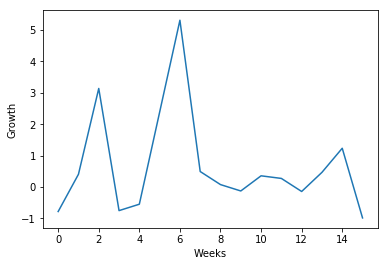

Store4
Averaged growth:
0.31


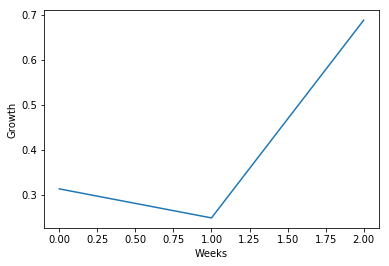

Store5
Averaged growth:
0.21


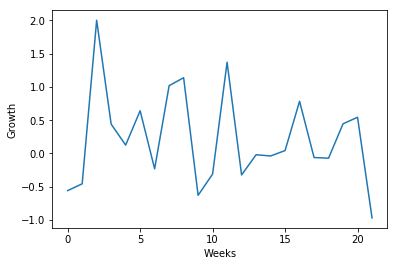

Store7
Averaged growth:
1.14


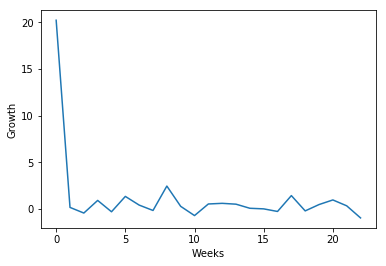

In [18]:
def diff_week(d1, d2):
    return (d1.year - d2.year) * 52 + d1.week - d2.week

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

store_list = ['Store3','Store4','Store5','Store7']

for item in store_list:
    tmp = transc_data.loc[transc_data['Store_new']==item].sort_values(['Order date'])
    tmp = tmp.reset_index()
    tmp['week'] = tmp['Order date'].map(lambda x: diff_month(x,tmp['Order date'].iloc[0]))
    tmp = tmp[['week','Line_Total']].groupby('week').sum()
    tmp = tmp.reset_index()
    tmp.columns = ['week', 'week_sum']
    print(item)   
    tmp['growth'] = (tmp['week_sum'].shift(-1)-tmp['week_sum'])/tmp['week_sum']
    print("Averaged growth:")
    print(round(tmp['growth'].sum()/tmp['growth'].shape[0],2))
    
    plt.plot(tmp['week'],tmp['growth'])  
    plt.xlabel('Weeks')
    plt.ylabel('Growth')
    plt.show()

**Store7 has the highest growth rate and Store5 has the least.**

### (10) Forecast total sales for 2018 in total, by store and by product.


Note:

    1) Month wise predictions calculated
    2) To avoid lot of variation, only two months into 2018 are predicted for each store.
    3) Prophet model is used to get the forecast.
    4) The "prophet_model" function also accounts for modelling with respect to store and product

In [19]:
def prophet_model(var_transc_data, store_prod, prod_flag = False ):
    if prod_flag:
        store_order_data = var_transc_data[['Product','Order date','Order_ID', 'Line_Total']
                                     ].loc[transc_data['Product']== store_prod].groupby([
                                          'Order_ID','Order date',]).sum()
    else:
        store_order_data = var_transc_data[['Store_new','Order date',
                                    'Order_ID', 'Line_Total']
                                     ].loc[transc_data['Store_new']== store_prod].groupby([
                                          'Order_ID','Order date','Store_new']).sum()
    
    
    store_order_data = store_order_data.reset_index()
    store_order_data['Order date']=store_order_data['Order date'].dt.date

    ##finding sum of two order dates, in months
    store_order_data['month'] = store_order_data['Order date'].map(lambda x: diff_month(x,store_order_data['Order date'].iloc[0]))

    modelling_data = store_order_data.groupby('month').agg({'Order date': 'min','Line_Total':'sum'})

    modelling_data = modelling_data.reset_index()
    modelling_data = modelling_data[['Order date', 'Line_Total']]
    modelling_data.columns = ['ds','y']

    ##fitting the prophet model
    model = Prophet() 
    model.fit(modelling_data)
    future_data=model.make_future_dataframe(periods=2, freq = 'm')

    forecast_data = model.predict(future_data)
    return forecast_data, model

In [20]:
##Store 3,4,5,7 considered as mentioned before
forecast_store3, model_store3 = prophet_model(transc_data, 'Store3')
forecast_store4, model_store4 = prophet_model(transc_data, 'Store4')
forecast_store5, model_store5 = prophet_model(transc_data, 'Store5')
forecast_store7, model_store7 = prophet_model(transc_data, 'Store7')

In [21]:
#there are 5 different products
prod_list = list(transc_data['Product'].unique())
forecast_footwear, model_footwear = prophet_model(transc_data, prod_list[0], True)
forecast_clothing, model_clothing = prophet_model(transc_data, prod_list[1], True)
forecast_accessories, model_accessories = prophet_model(transc_data, prod_list[2], True)
forecast_houseware, model_houseware = prophet_model(transc_data, prod_list[3], True)
forecast_perfume, model_perfume = prophet_model(transc_data, prod_list[4], True)

**The following plot is of only one model, others similarly could be plotted.**

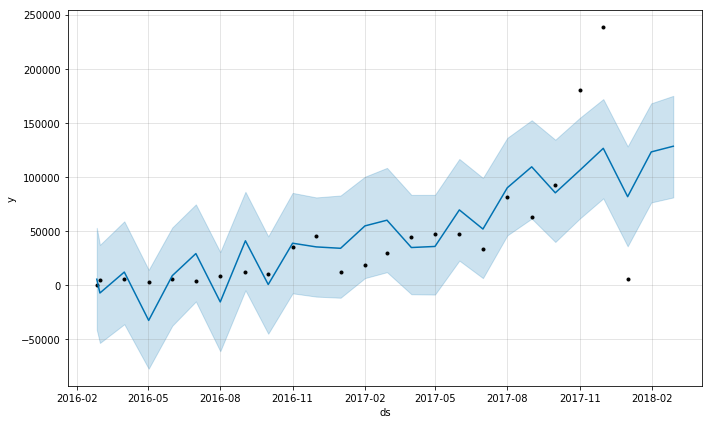

In [22]:
model_store7.plot(forecast_store7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
plt.show()

In [23]:
print("Prediction for Month of January 2018 (Using Store level data):")
round(float(forecast_store3[['yhat']].loc[forecast_store3.shape[0]-2])+\
float(forecast_store4[['yhat']].loc[forecast_store4.shape[0]-2])+\
float(forecast_store5[['yhat']].loc[forecast_store5.shape[0]-2])+\
float(forecast_store7[['yhat']].loc[forecast_store7.shape[0]-2]),2)


Prediction for Month of January 2018 (Using Store level data):


146656.54

In [24]:
print("Prediction for Month of February 2018 (Using Store level data):")
round(float(forecast_store3[['yhat']].loc[forecast_store3.shape[0]-1])+\
float(forecast_store4[['yhat']].loc[forecast_store4.shape[0]-1])+\
float(forecast_store5[['yhat']].loc[forecast_store5.shape[0]-1])+\
float(forecast_store7[['yhat']].loc[forecast_store7.shape[0]-1]),2)

Prediction for Month of February 2018 (Using Store level data):


155481.63

In [25]:
print("Prediction for January 2018 (Using product level data):")
round(float(forecast_footwear[['yhat']].loc[forecast_footwear.shape[0]-2])+\
float(forecast_clothing[['yhat']].loc[forecast_clothing.shape[0]-2])+\
float(forecast_accessories[['yhat']].loc[forecast_accessories.shape[0]-2])+\
float(forecast_houseware[['yhat']].loc[forecast_houseware.shape[0]-2])+\
float(forecast_perfume[['yhat']].loc[forecast_perfume.shape[0]-2]),2)

Prediction for January 2018 (Using product level data):


136330.08

In [26]:
print("Prediction for February 2018 (Using product level data):")
round(float(forecast_footwear[['yhat']].loc[forecast_footwear.shape[0]-1])+\
float(forecast_clothing[['yhat']].loc[forecast_clothing.shape[0]-1])+\
float(forecast_accessories[['yhat']].loc[forecast_accessories.shape[0]-1])+\
float(forecast_houseware[['yhat']].loc[forecast_houseware.shape[0]-1])+\
float(forecast_perfume[['yhat']].loc[forecast_perfume.shape[0]-1]),2)

Prediction for February 2018 (Using product level data):


141893.29

### (11) If there are multiple item orders, which 2 products are most likely to go together? Do customers buy different products all together, or the same product with different Brand, or the same product with the same brand but different sizes, or any other combination?


In [27]:
##dataframe subset on items over 1 in order
order_multiple_items = order_count.loc[order_count['count_items']>1]

##creating a cart list for all the orders with multiple items
cart_list = []
for item in order_multiple_items.index:
    tmp = transc_data.loc[transc_data['Order_ID']==item]
    cart = []
    for row in tmp.values:
        cart.append(row[8]+'_'+row[10])
    cart_list.append(cart)

In [28]:
##creating a dataframe which stores the association among the items bought together
pattern = TransactionEncoder()
pattern_arr = pattern.fit(cart_list).transform(cart_list)
pattern_df = pd.DataFrame(pattern_arr, columns=pattern.columns_)
pattern_df.head()    

,Accessories_FB,Accessories_LMW,Accessories_NC0,Clothing_ABB,Clothing_KLL,Clothing_KMM,Clothing_KNN,Clothing_KOC,Clothing_KOO,Clothing_KPP,...,Footwear_WLC,Footwear_WLG,Footwear_WLS,Houseware_CAR,Perfumes_BOO,Perfumes_DGC,Perfumes_KJO,Perfumes_KRR,Perfumes_LBW,Perfumes_NCW
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
##Using Apriori algorithm to find the most common supporting items in a set and ordering them 
##with respect to support vals
frequent_itemsets = apriori(pattern_df, min_support=0.05, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
frequent_itemsets.head()

,support,itemsets,length
6,0.484906,(Footwear_NCW),1
2,0.361321,(Footwear_ABC),1
0,0.137736,(Clothing_ABB),1
8,0.131132,"(Footwear_NCW, Footwear_ABC)",2
4,0.120755,(Footwear_KBB),1


In [30]:
##subset of frequently bought item when order contains two elements.
frequent_two_item = frequent_itemsets[ (frequent_itemsets['length'] == 2) ]
print("Number of such pairs:")
print(frequent_two_item.shape[0])
print("Items bought together, with descending amount of support:")
frequent_two_item.head()


Number of such pairs:
2
Items bought together, with descending amount of support:


,support,itemsets,length
8,0.131132,"(Footwear_NCW, Footwear_ABC)",2
7,0.050943,"(Footwear_NCW, Clothing_ABB)",2


**People are seen to buy same product with different brand as well as different products. Though same product, different brands is more common.**

### (12) What % of total site traffic is free? Is this proportion of free traffic increasing, decreasing or staying same over the time?

In [31]:
##Only 7 of 11 marketing channels are considered.
sum_df = traffic_data[['Default Channel Grouping','Sessions']].groupby(['Default Channel Grouping']).sum()


free_traffic = float(sum_df.loc['Direct']+sum_df.loc['(Other)']+\
                     sum_df.loc['Organic Search']+sum_df.loc['Referral']+\
                    sum_df.loc['Social']+sum_df.loc['Email']+sum_df.loc['Other Advertising'])

total_sum = float(sum_df.Sessions.sum())
print('Free site traffic %:')
print(round(free_traffic/total_sum*100,2))


Free site traffic %:
56.2


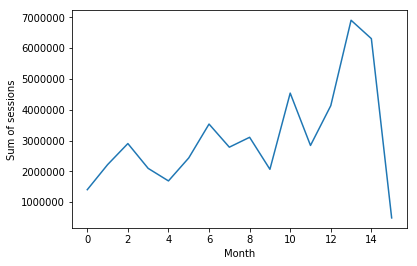

In [32]:
##Sum of count of Sessions for each month
traffic_subset = traffic_data.loc[traffic_data['Default Channel Grouping'].isin(['Organic Search'
                'Direct','(Other)','Email','Other Advertising','Social','Referral']) ].sort_values(['Date'])


traffic_subset['month'] = traffic_subset['Date'].map(lambda x: diff_month(x,traffic_subset['Date'].iloc[0]))

plt.plot(traffic_subset[['month','Sessions']].groupby('month').sum())
plt.xlabel('Month')
plt.ylabel('Sum of sessions')
plt.show()

**The number of sessions are clearly increasing over the months. Note: The last month is not complete, as it has only about less than one week of data.**

### (13) What is the site conversion rate?

**Note:**
    This question is a little confusing as we don't have any session mapped to the order.
    It is difficult to find the site conversion rate without the above information.
    The following code sums the number of sessions, irrespective of channel on a daily basis and maps it to number of orders completed on that day.

In [33]:
traffic_ordered = traffic_data.sort_values(['Date'])
traffic_date = traffic_ordered[['Date','Sessions']].groupby('Date').sum()
traffic_date = traffic_date.reset_index()
traffic_date.head()

,Date,Sessions
0,2016-10-01,54959
1,2016-10-02,55557
2,2016-10-03,58012
3,2016-10-04,59580
4,2016-10-05,61609


In [34]:
transc_subset = transc_data.loc[transc_data['Store_new']=='Store7'].sort_values('Order date')
transc_subset['Order date'] = transc_subset['Order date'].dt.date
transc_date_count = transc_subset[['Order date', 'Order_ID']].groupby('Order date').Order_ID.nunique()
transc_date_count = transc_date_count.reset_index()
transc_date_count.columns = ['Date','order_count']
transc_date_count.head()

,Date,order_count
0,2016-02-26,2
1,2016-02-29,1
2,2016-03-01,8
3,2016-03-02,4
4,2016-03-03,7


In [35]:
order_session_map = pd.merge(traffic_date,transc_date_count, on = 'Date')
order_session_map.head()

,Date,Sessions,order_count
0,2016-10-01,54959,1
1,2016-10-02,55557,3
2,2016-10-03,58012,3
3,2016-10-04,59580,2
4,2016-10-05,61609,4


If we had the necessary information, the Sessions cols above would be lot small (and comparable to order_count). Which would have been benificial calculating the site conversion rate.

### (14) Quantify the role of paid marketing in gross sales.


**Assumption:** The paid marketing will impact the gross sales in the same ratio of it to total number of sessions

In [37]:
paid_traffic = float(sum_df.loc['Paid Social']+sum_df.loc['Paid Search']+\
                     sum_df.loc['Display']+sum_df.loc['Affiliates'])
paid_percent = paid_traffic/sum_df['Sessions'].sum()

print("Paid marketing percent of total sessions:")
print(round(paid_percent*100,2),'%')
print("Paid marketing contribution to gross sales:")
print(round(transc_data['Line_Total'].sum()*paid_percent,2))

Paid marketing percent of total sessions:
43.8 %
Paid marketing contribution to gross sales:
508384.16


The above numbers has a major assumption behind it. Though with more data, this could be improved.

### (15) Quantify the role of paid marketing in new customer acquisition.


** Assumption:** The paid marketing will impact the new customer acquisition in the same ratio of it to total number of sessions

In [38]:
contri_customer_split = transc_data[['Returning_Customer (1=Yes/0=No)',
             'Line_Total']].groupby('Returning_Customer (1=Yes/0=No)').sum()

print("Contribution to revenues with new customer acquisition by paid marketing:")
print(round(float(contri_customer_split.loc[0]*paid_percent),2))

Contribution to revenues with new customer acquisition by paid marketing:
306453.1


# (16) BONUS QUESTION: 
### Based on the data and analysis you performed, what are top 3 opportunities to increase growth and new customer acquisition?

In [39]:
traffic_data[['Default Channel Grouping',
              'Sessions']].groupby(['Default Channel Grouping']).sum().sort_values('Sessions').head(3)

,Sessions
Default Channel Grouping,
Paid Social,1231809
Social,1306967
Other Advertising,1612264


The top three channels through which we get the most of the sessions are :

    1) Paid Social
    2) Social
    3) Other Advertising

In [40]:
frequent_itemsets.head()

,support,itemsets,length
6,0.484906,(Footwear_NCW),1
2,0.361321,(Footwear_ABC),1
0,0.137736,(Clothing_ABB),1
8,0.131132,"(Footwear_NCW, Footwear_ABC)",2
4,0.120755,(Footwear_KBB),1


Discussing with the business we can discuss on different strategies concentrating different items with **top support from Apriopri Algorithm.**

We can concentrate on brands like **ABB, ABC and NCW** as they are known to give us the **highest customer acquisition. Footwear and clothing** products too are known to attract a lot of customers, keeping a **referral or one time coupon system** can be thought of for particular subsets.